# Notebook 2 (LSTM): update of LSTM models with new data and biases calculations
Notebook contains updates of each LSTM model with new data, which has been collected from to 2016-01-01 00:00 to 2022-12-30 23:30.

Update of each model is tested on different sizes of batches.

Evaluation of each model's predictions is made by taking average of MAE calculations (mean absolute error) made for each update set.

## All necessary libraries imports

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras.layers import *
from sklearn.metrics import mean_absolute_error

Imports from helpful_functions.python script located in root/notebooks folder.

In [13]:
from helpful_functions import  min_max_denormalization, transform_data 

## Files to load

In [14]:
# minimum and maximum values for denormalization read
min_and_max = pd.read_csv("generated_models/lstm_models/min_and_max")
min = min_and_max['min']
max = min_and_max['max']

In [15]:
# read the CSV file with data for updating each model
# update data is the same as the test data from Notebook 1
data = pd.read_csv("all_data/data_for_main_model/data_ready_for_testing.csv")
update_data = data[["relh", "skph", "temp"]]

In [16]:
# read all models for updates
# model for predictions in next hour
model1 = pickle.load(open("generated_models/lstm_models/lstm_1.pkl", "rb", -1))

# model for predictions in two hours
model2 = pickle.load(open("generated_models/lstm_models/lstm_2.pkl", "rb", -1))

# model for predictions in three hours
model3 = pickle.load(open("generated_models/lstm_models/lstm_3.pkl", "rb", -1))

## Update model with new data

In [17]:
def update_and_predict(epochs = 10, window_size=12, size_of_timestamps_in_updating_set = 320, number_of_updates = 10): # (size_of_timestamps = 336) == 7 days

    # log
    print(f"\nStart of the models update with {epochs} epochs and {size_of_timestamps_in_updating_set} timestamps as size of updating set.\n")
    
    # data frame to numpy matrix
    data = update_data.to_numpy()

    # lists for MAE and biases to collect
    MAE_humid_all_models = []
    MAE_wind_all_models = []
    MAE_temp_all_models = []
    bias_humid_all_models = []
    bias_wind_all_models = []
    bias_temp_all_models = []

    # number of updates to execute
    how_many_updates = number_of_updates # int(update_data.shape[0]/size_of_timestamps_in_updating_set)-1

    # last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
    last_pred_hour = 3
    for hour in range(1,last_pred_hour*2,2):
        
        # temporary lists for MAE and biases reseted for updates for each hour/ each model
        MAE_humid = []
        MAE_wind = []
        MAE_temp = []
        bias_humid = []
        bias_wind = []
        bias_temp = []
        
        # model choosement depends on for which hour predictions are going to be made
        if(hour == 1):
            LSTM_model = model1
        elif(hour == 3):
            LSTM_model = model2
        else:
            LSTM_model = model3
        # log
        print(f"\n #### Start of the model update for predictions in {(hour+1)/2} hour/s. ####")

        for update in range(how_many_updates):

            # data for update
            data_patch_update = data[update * size_of_timestamps_in_updating_set : (update+1) * size_of_timestamps_in_updating_set + window_size + hour]
            X, y = transform_data(data_patch_update, max, min, timestamps_count = hour, is_update = True)

            len = y.shape[0]
            len = y.shape[0] - (y.shape[0] % (32))
            X = X[:len]
            y = y[:len]  

            # # probe is data splitted in correct way #################
            # # vect = np.linspace(1,len(data_patch_update),len(data_patch_update))
            # # temp = [r[2] for r in data_patch_update[:]]
            # # plt.plot(temp,vect+(update)*data_patch_update.shape[0])
            # #########################################################

            # data for test
            data_patch_test = data[(update+1) * size_of_timestamps_in_updating_set : (update+2) * size_of_timestamps_in_updating_set + window_size + hour]
            X_test, y_test = transform_data(data_patch_test, max, min, timestamps_count = hour, is_update = True)
            len = y_test.shape[0]
            len = y_test.shape[0] - (y_test.shape[0] % (32))
            X_test = X_test[:len]
            y_test = y_test[:len]
            
            LSTM_model.reset_states()
            LSTM_model.fit(X, y,  epochs=epochs, shuffle=False ,verbose = 0,batch_size=32)

            # make predictions
            LSTM_model.reset_states()
            predictions = LSTM_model.predict(X_test, verbose = 0, batch_size=32)

            pred = []
            actual =[]

            # data denormalization
            weather_components_size = y.shape[1]
            for i in range(weather_components_size):
                pred.append(min_max_denormalization(predictions[:, i], max[i], min[i]))
                actual.append(min_max_denormalization(y_test[:, i], max[i], min[i]))

            # MSE for predicted and actual values
            MAE_humid.append(mean_absolute_error(actual[0], pred[0]))
            MAE_wind.append(mean_absolute_error(actual[1], pred[1]))
            MAE_temp.append(mean_absolute_error(actual[2], pred[2]))

            # biases
            bias_humid.append(sum(pred[0] - actual[0])/(pred[0].shape[0]))
            bias_wind.append(sum(pred[1] - actual[1])/(pred[0].shape[0]))
            bias_temp.append(sum(pred[2] - actual[2])/(pred[0].shape[0]))
        
        # print results
        print(f"\nMAE value for relative humidity: {np.mean(MAE_humid)}")
        print(f"MAE value for speed of wind: {np.mean(MAE_wind)}")
        print(f"MAE value for temperature: {np.mean(MAE_temp)}")

        # save MAE (for each model)
        MAE_humid_all_models.append(MAE_humid)
        MAE_wind_all_models.append(MAE_wind)
        MAE_temp_all_models.append(MAE_temp)

        # save biases (for each model)
        bias_humid_all_models.append(bias_humid)
        bias_wind_all_models.append(bias_wind)
        bias_temp_all_models.append(bias_temp)

    # note: pred and actual are not normalized!
    return MAE_humid_all_models, MAE_wind_all_models, MAE_temp_all_models, bias_humid_all_models, bias_wind_all_models, bias_temp_all_models

## Checking how huge should be data for each update and different epoch size
In each scenario models will be updated with data collected in one year.

In [18]:
# # checking how huge should be data for each update and different epochs

# # checking with 1, 7 and 30 days
# update_batch_size_in_days = [1,7,30]
# # number of updates to make for different size of batch of days
# # in each scenario models are updated with data from one year 
# number_of_updates = [365,52,12]

# # checking with 5 and 10 number of epochs
# number_of_epochs = [5,10]

# # variable for proper enumeration of number_of_updates
# index = 0
# for number_of_days in update_batch_size_in_days:
#     for epoch in number_of_epochs:
#         # evoke update_and_predict function
#         _, _, _, _, _, _ = update_and_predict(epochs = epoch, size_of_timestamps_in_updating_set = 48 * number_of_days, number_of_updates = number_of_updates[index])
#     index+=1
        

## Updates for 5 as number of epochs and 7 as number of days in each update batch
Updates with data from the beginning of 2016 till the end of 2021.

In [19]:
# parameters for models updates
epoch = 5
# for: number_of_days = 7 and number_of_updates = 312 - it is data from the beginning of 2016 till the end of 2021
number_of_days = 7
number_of_updates = 328

MAE_humid, MAE_wind, MAE_temp, biases_humid, biases_wind, biases_temp = update_and_predict(epochs = epoch, size_of_timestamps_in_updating_set = 320, number_of_updates=number_of_updates)


Start of the models update with 5 epochs and 320 timestamps as size of updating set.


 #### Start of the model update for predictions in 1.0 hour/s. ####

MAE value for relative humidity: 3.8392727009221543
MAE value for speed of wind: 2.662171292022191
MAE value for temperature: 0.6903940800304821

 #### Start of the model update for predictions in 2.0 hour/s. ####

MAE value for relative humidity: 5.521253817203568
MAE value for speed of wind: 3.370899304095502
MAE value for temperature: 1.1077262048132537

 #### Start of the model update for predictions in 3.0 hour/s. ####

MAE value for relative humidity: 6.914688810501156
MAE value for speed of wind: 3.8839031623943066
MAE value for temperature: 1.4301973268934867


Results

The plots shows MAE calculated for each update set and different model. X-axis is the number of update and the y-axis shows MAE error, which is in % for relative humidity, km/h for speed of wind and °C for temperature.

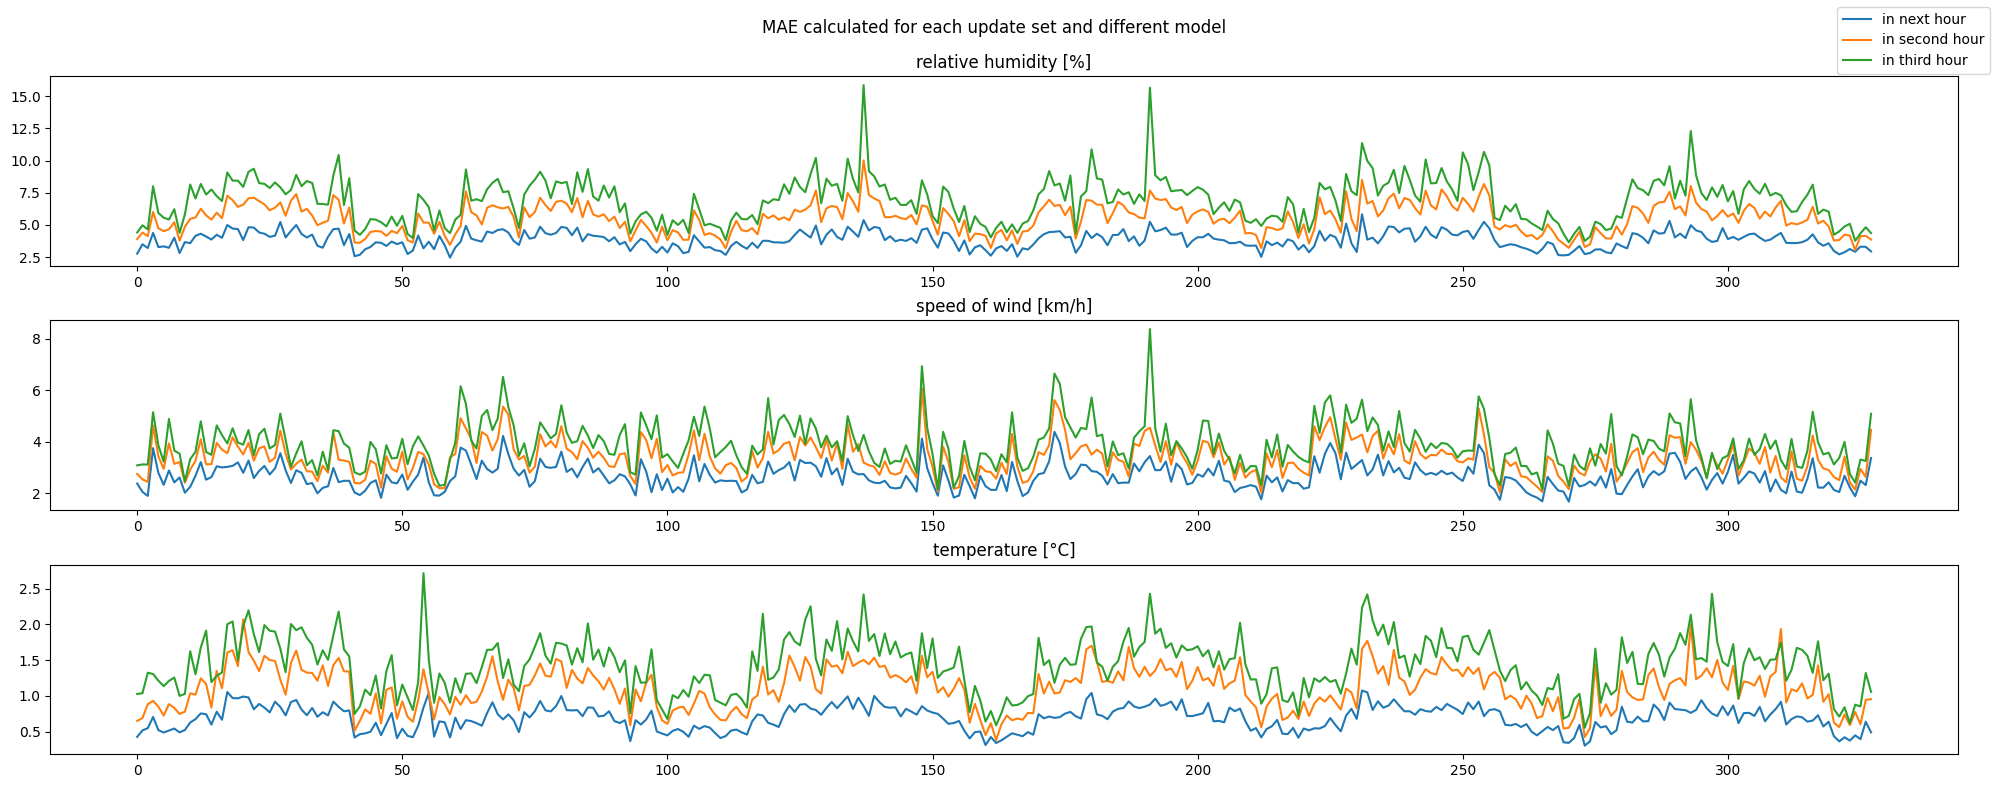

In [20]:
fig, axs = plt.subplots(3,figsize=(20, 8))
fig.suptitle(
        "MAE calculated for each update set and different model"
)
fig.tight_layout(pad=1.8)

# add data to each subplot
axs[0].plot(MAE_humid[0], label = 'in next hour')
axs[0].plot(MAE_humid[1], label = 'in second hour')
axs[0].plot(MAE_humid[2], label = 'in third hour')
axs[0].set_title("relative humidity [%]")

axs[1].plot(MAE_wind[0])
axs[1].plot(MAE_wind[1])
axs[1].plot(MAE_wind[2])
axs[1].set_title("speed of wind [km/h]")

axs[2].plot(MAE_temp[0])
axs[2].plot(MAE_temp[1])
axs[2].plot(MAE_temp[2])
axs[2].set_title("temperature [°C]")

fig.legend()

Display biases.

In [21]:
# add biases to data frame
biases = pd.DataFrame()
# add hour to the frame
biases['hour'] = [1,2,3]
biases['humid'] = [np.mean(biases_humid[0]),np.mean(biases_humid[1]),np.mean(biases_humid[2])]
biases['wind'] = [np.mean(biases_wind[0]),np.mean(biases_wind[1]),np.mean(biases_wind[2])]
biases['temp'] =  [np.mean(biases_temp[0]),np.mean(biases_temp[1]),np.mean(biases_temp[2])]

In [22]:
# display biases for each hour
biases

,hour,humid,wind,temp
0,1,0.041822,-0.015342,-0.010638
1,2,0.095385,-0.063734,-0.041962
2,3,0.035750,-0.031732,-0.029324


Biases for each weather component are small and won't be considered in the future.